In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import seaborn as sns
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os
import torch
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
import math

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 


In [75]:
rsna_df = pd.read_csv("/kaggle/input/rsna-bone-age/boneage-training-dataset.csv")
test_rsna_df = pd.read_csv("/kaggle/input/rsna-bone-age/boneage-test-dataset.csv")

In [76]:
test_rsna_df.head(3)

,Case ID,Sex
0,4360,M
1,4361,M
2,4362,M


In [77]:
image_path = {}
for path in glob('/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/*png'):
    img_id = os.path.splitext(os.path.basename(path))[0]
    image_path[img_id] = path

In [78]:
image_path_test = {}
for path in glob('/kaggle/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset/*png'):
    img_id = os.path.splitext(os.path.basename(path))[0]
    image_path_test[img_id] = path

In [79]:
rsna_df['id'] = rsna_df['id'].astype(str)
rsna_df['path'] = rsna_df['id'].map(image_path)

In [81]:
test_rsna_df['Case ID'] = test_rsna_df['Case ID'].astype(str)
test_rsna_df['path'] = test_rsna_df['Case ID'].map(image_path_test)
test_rsna_df

,Case ID,Sex,path
0,4360,M,/kaggle/input/rsna-bone-age/boneage-test-datas...
1,4361,M,/kaggle/input/rsna-bone-age/boneage-test-datas...
2,4362,M,/kaggle/input/rsna-bone-age/boneage-test-datas...
3,4363,M,/kaggle/input/rsna-bone-age/boneage-test-datas...
4,4364,M,/kaggle/input/rsna-bone-age/boneage-test-datas...
...,...,...,...
195,4555,F,/kaggle/input/rsna-bone-age/boneage-test-datas...
196,4556,F,/kaggle/input/rsna-bone-age/boneage-test-datas...
197,4557,F,/kaggle/input/rsna-bone-age/boneage-test-datas...
198,4558,F,/kaggle/input/rsna-bone-age/boneage-test-datas...


In [6]:
rsna_df['gender'] = rsna_df['male'].replace({False: 'Female',True: 'Male'})
rsna_df['sex'] = rsna_df['gender'].replace({"Female" : 0, "Male": 1}) 

In [7]:
rsna_df.sample(4)

,id,boneage,male,path,gender,sex
2292,3927,94,False,/kaggle/input/rsna-bone-age/boneage-training-d...,Female,0
12322,15288,192,True,/kaggle/input/rsna-bone-age/boneage-training-d...,Male,1
688,2148,140,False,/kaggle/input/rsna-bone-age/boneage-training-d...,Female,0
3794,5781,144,False,/kaggle/input/rsna-bone-age/boneage-training-d...,Female,0


# **Exploratory Data Analysis**

<Axes: xlabel='gender'>

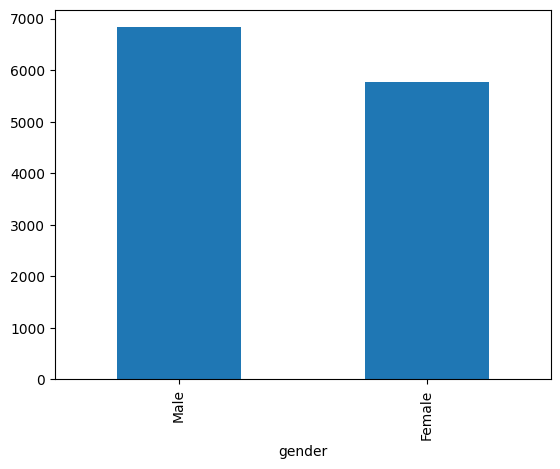

In [8]:
rsna_df['gender'].value_counts().plot(kind = "bar")

<Axes: xlabel='boneage', ylabel='Count'>

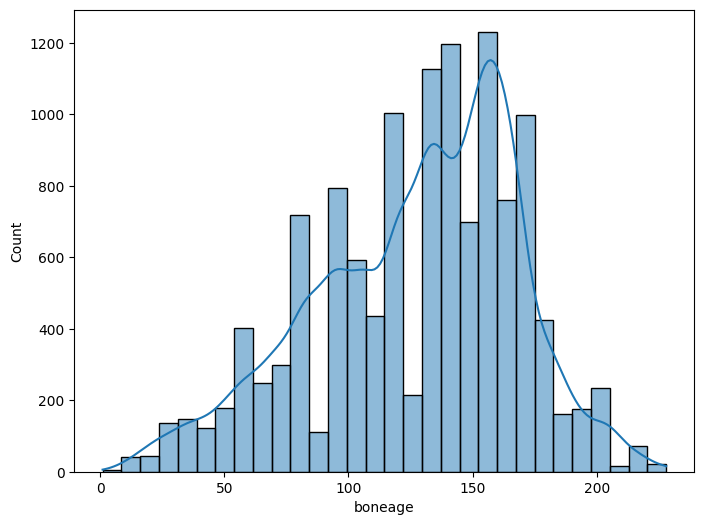

In [9]:
plt.figure(figsize=(8, 6))
sns.histplot(rsna_df['boneage'], bins=30, kde=True)

<Axes: xlabel='boneage', ylabel='Density'>

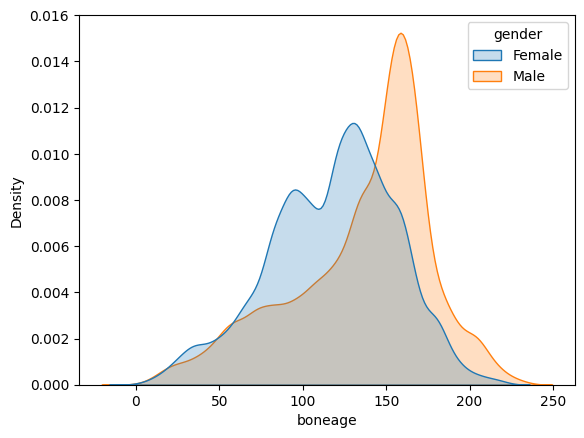

In [10]:
sns.kdeplot(data=rsna_df, x='boneage', hue='gender', fill=True, common_norm=False)

<Axes: xlabel='gender', ylabel='boneage'>

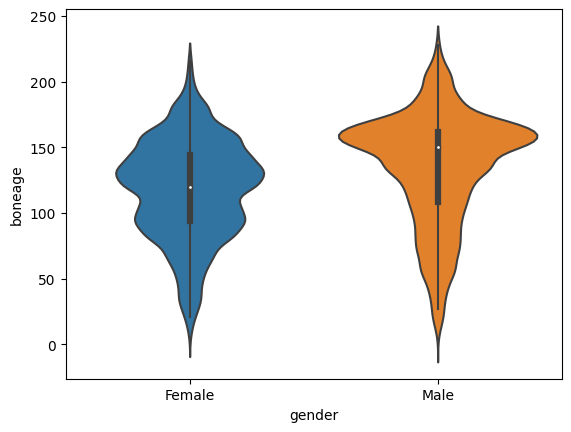

In [11]:
sns.violinplot(data=rsna_df, x='gender', y='boneage')

In [12]:
rsna_df.groupby('gender')['boneage'].max()

gender
Female    216
Male      228
Name: boneage, dtype: int64

 ## **Image Visualization**

In [13]:
rsna_sample = rsna_df.sample(6)
sample_paths  = []
for i in range(rsna_sample.shape[0]):
    path = rsna_sample.values.tolist()[i][3]
    sample_paths.append(path)
    
sample_paths

['/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/4643.png',
 '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/11797.png',
 '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/4096.png',
 '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/5666.png',
 '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/10536.png',
 '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/14755.png']

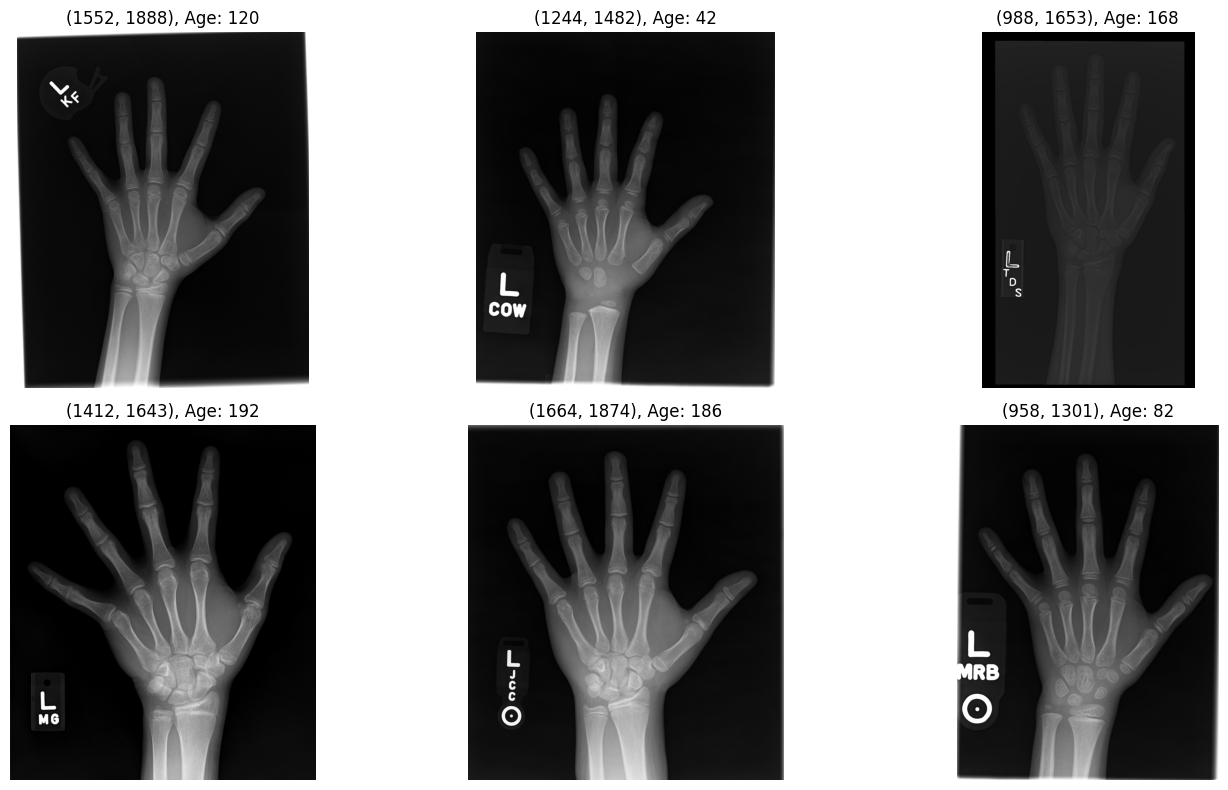

In [14]:
plt.figure(figsize = (15, 8))

for i, img_p in enumerate(sample_paths):
    plt.subplot(2, 3, i+1)
    img = Image.open(img_p)
    im_id = os.path.splitext(os.path.basename(img_p))[0]
    plt.imshow(img, cmap = "gray")
    plt.axis('off')
    plt.title(f"{img.size}, Age: {rsna_df.loc[rsna_df['id'] == (im_id), 'boneage'].values[0]}")
    
plt.tight_layout()  
plt.show()

In [18]:
class BoneAgeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']  # Get image path
        image = Image.open(img_path)  # Open image

        if self.transform:
            images = self.transform(image)  # Apply transformations

        boneage = self.df.iloc[idx]['boneage']  # Get bone age label
        return images, boneage


In [20]:
# Training Transformations (with data augmentation)
train_transform = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=40, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

# Testing Transformations (minimal preprocessing)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_df, test_df = train_test_split(rsna_df, test_size=0.2, random_state=42)
# Apply transformations
train_dataset = BoneAgeDataset(train_df, transform=train_transform)
test_dataset = BoneAgeDataset(test_df, transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [21]:
for images, boneage in train_loader:
    print(images[0].dtype, boneage[0].dtype)
    break

torch.float32 torch.int64


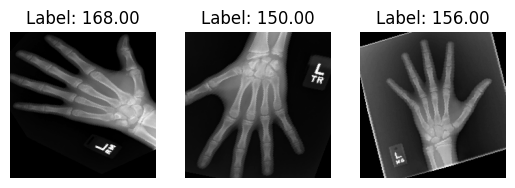

In [22]:
for i, (images, boneage) in enumerate(train_loader):
    if i >= 3:
        break
        
    if isinstance(images, torch.Tensor):      
        image = transforms.ToPILImage()(images[0])
        
    plt.subplot(1, 3, i + 1)
    plt.imshow(image, cmap='gray')  
    plt.title(f"Label: {boneage[0].item():.2f}")  
    plt.axis("off")
    
plt.show()

In [23]:
for images, boneage in train_loader:
    print("Image at index 1:", images[1].shape)  # This prints the shape of the second image
    print("Bone age at index 1:", boneage[1].item())  # This prints the second bone age value
    print("Min bone age in this batch:", boneage.min().item())  # This prints the min bone age in the batch
    break


Image at index 1: torch.Size([1, 224, 224])
Bone age at index 1: 106
Min bone age in this batch: 36


In [49]:
class BoneAgePretrainedNet(nn.Module):
    def __init__(self):
        super(BoneAgePretrainedNet, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        
    def forward(self, x):
        return self.base_model(x)



In [39]:
model = BoneAgePretrainedNet()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s] 


In [40]:
cuda_available = torch.cuda.is_available()
print("CUDA Available: ", cuda_available)
if cuda_available:
    device_name = torch.cuda.get_device_name(0)
    print("CUDA Device: ", device_name)

CUDA Available:  True
CUDA Device:  Tesla P100-PCIE-16GB


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(next(model.parameters()).device)

cuda:0


In [51]:
print(model)

BoneAgePretrainedNet(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

In [52]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.MSELoss()

In [53]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()  
    
    test_loss = 0.0
    all_predictions = []
    all_true_values = []

    with torch.no_grad():  
        for images, boneage in test_loader:
            images, boneage = images.to(device), boneage.to(device)
            boneage = boneage.float()
            boneage = boneage.view(-1, 1)
            
            outputs = model(images)  
            
            loss = criterion(outputs, boneage)  
            test_loss += loss.item()  
            all_predictions.extend(outputs.cpu().numpy())
            all_true_values.extend(boneage.cpu().numpy()) 
    test_loss /= len(test_loader)  
    mae = np.mean(np.abs(np.array(all_predictions) - np.array(all_true_values)))
    
    return test_loss, mae

In [54]:
train_losses = []
test_losses = []

num_epochs = 5
for epoch in range(num_epochs):
    model.train()  
    
    running_loss = 0.0
    for images, boneage in train_loader:
        images, boneage = images.to(device), boneage.to(device)
        boneage = boneage.float()
        boneage = boneage.view(-1, 1)

        optimizer.zero_grad()
        
        outputs = model(images)  
        loss = criterion(outputs, boneage)  
        loss.backward() 
        optimizer.step()  

        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    test_loss, mae = evaluate_model(model, test_loader, criterion, device)
    test_losses.append(test_loss)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}, MAE: {mae:.4f}")

Epoch 1/5, Training Loss: 766.4790, Test Loss: 709.1003, MAE: 19.7846
Epoch 2/5, Training Loss: 716.4226, Test Loss: 570.7760, MAE: 18.4473
Epoch 3/5, Training Loss: 683.1791, Test Loss: 710.3412, MAE: 20.5471
Epoch 4/5, Training Loss: 681.2359, Test Loss: 513.8965, MAE: 17.6022
Epoch 5/5, Training Loss: 649.5476, Test Loss: 506.3794, MAE: 17.3709


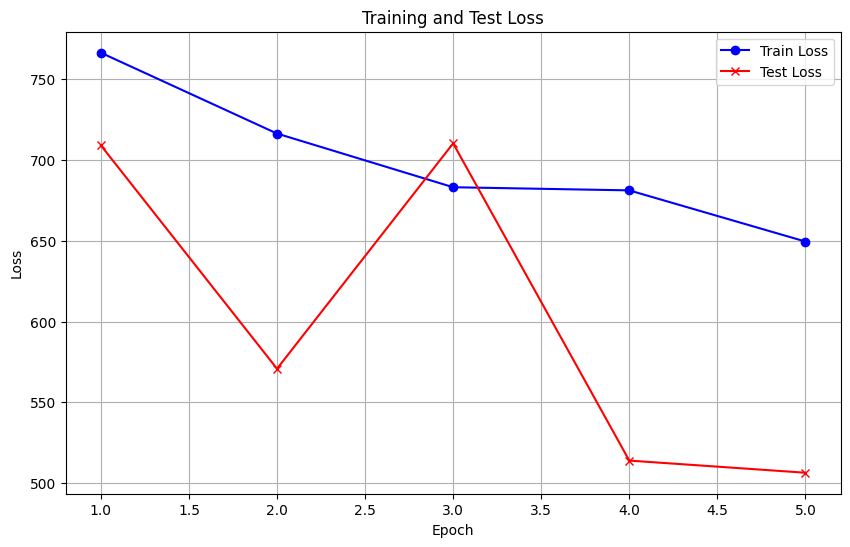

In [55]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss', color='red', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

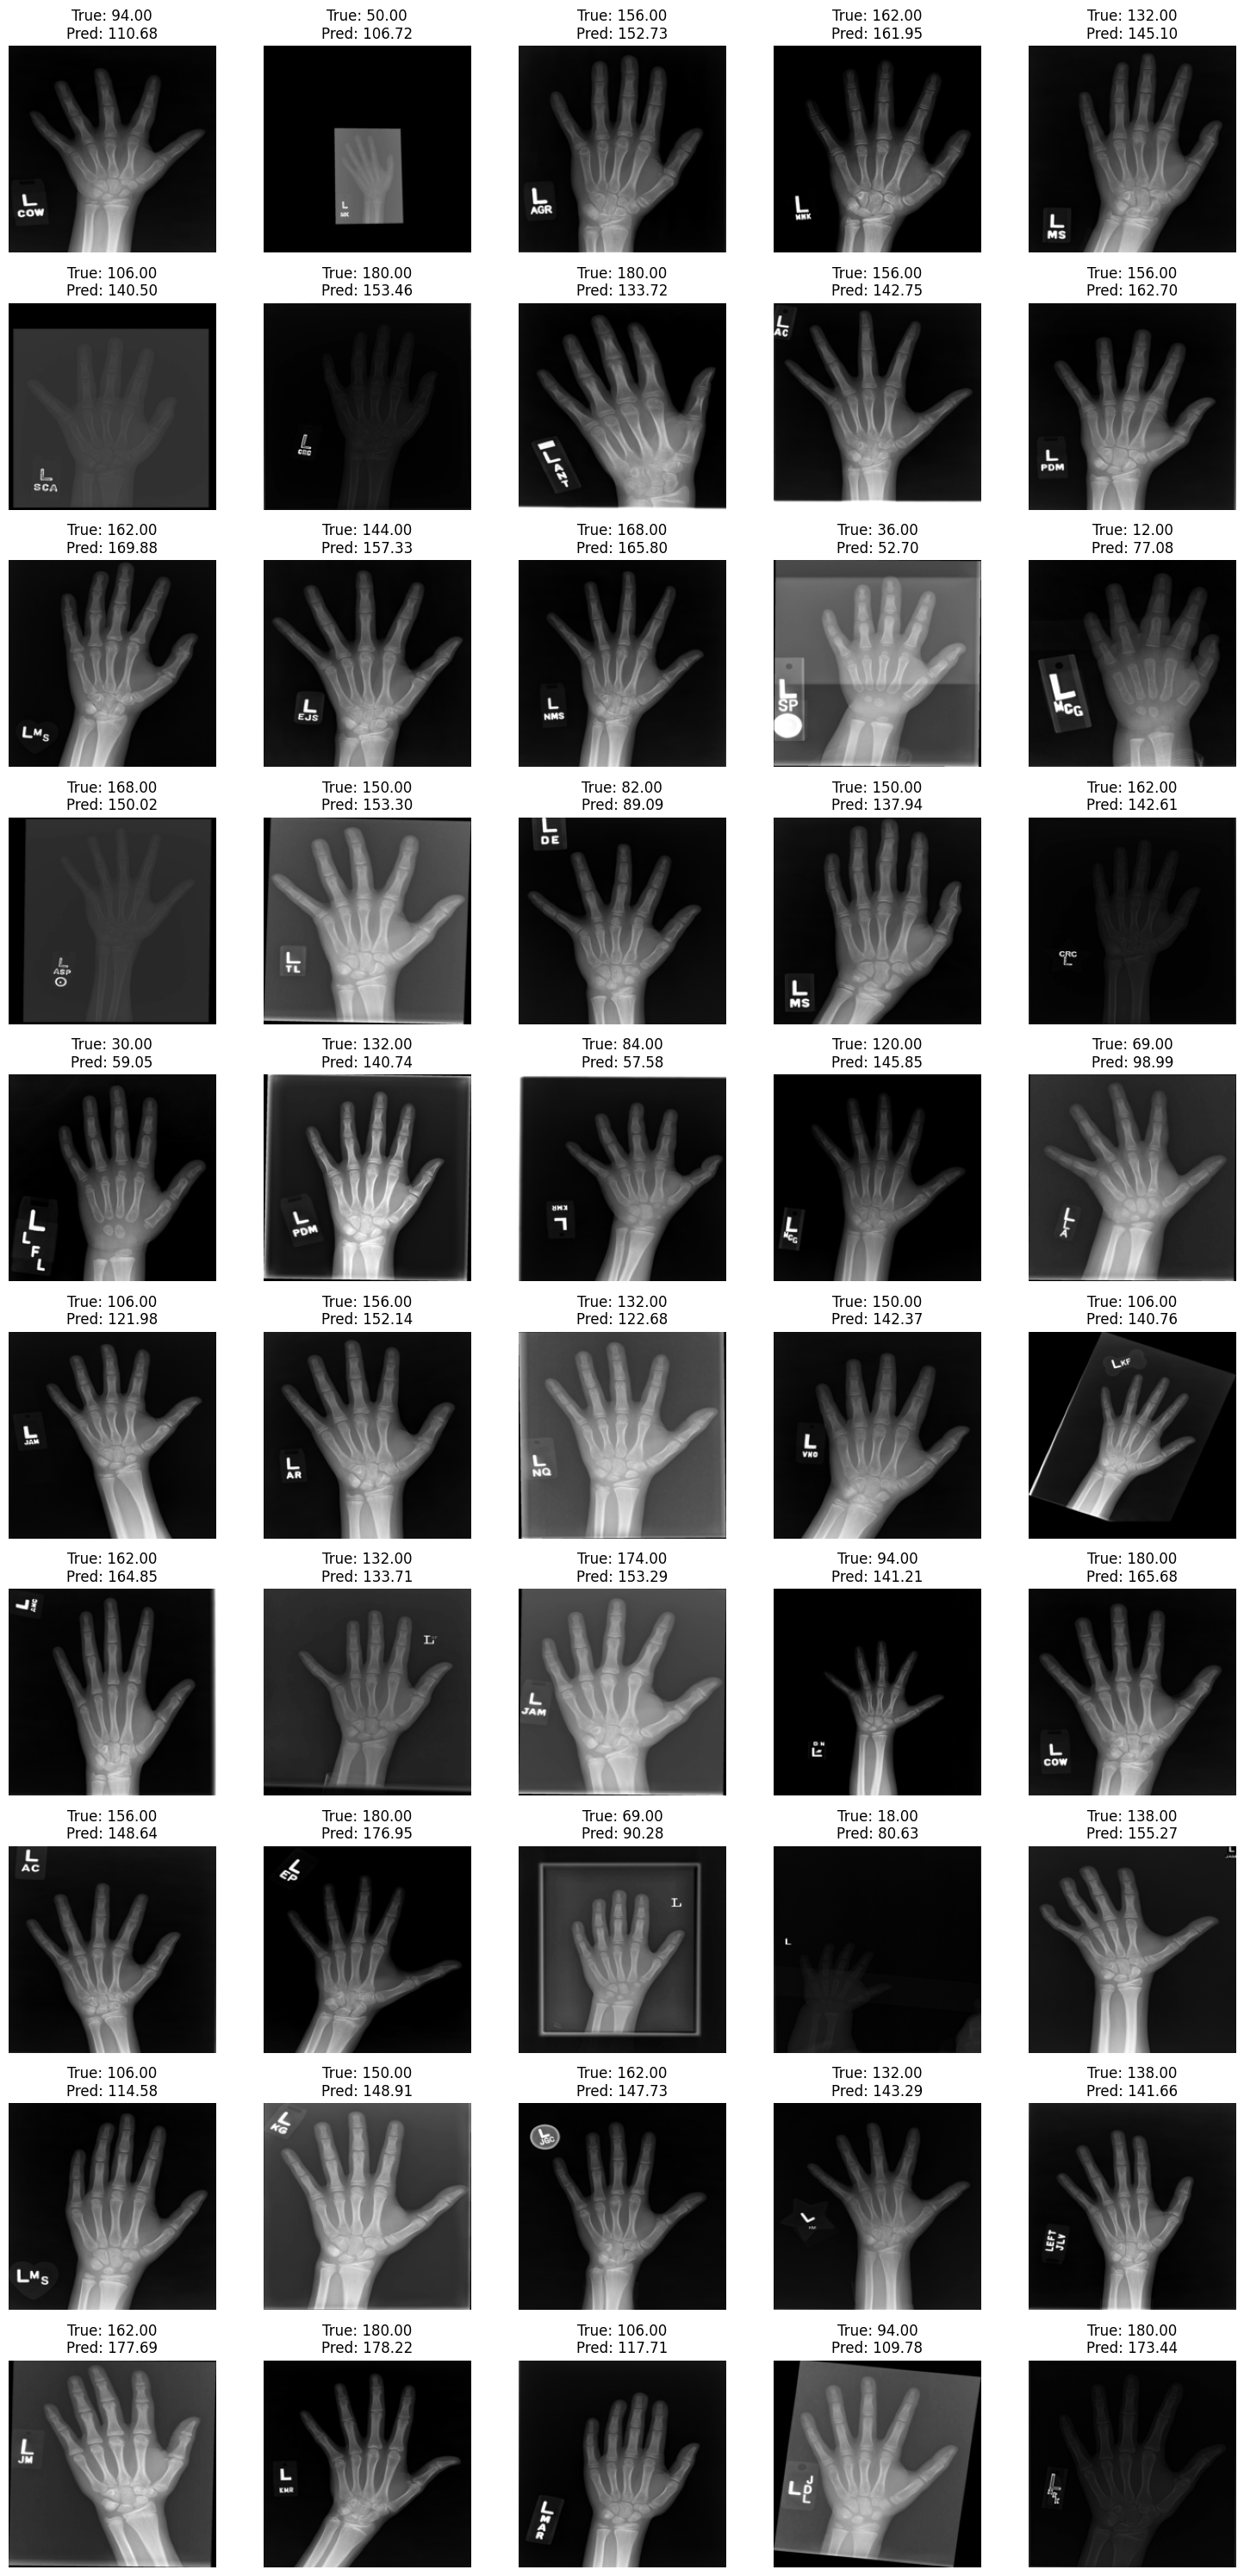

In [82]:
def plot_predictions(model, test_loader, num_samples, device='cuda'):
    model.eval()  
    data_iter = iter(test_loader)
    images, boneages = [], []
    predictions = []
    
    with torch.no_grad():
        for i in range(num_samples):
            img, boneage = next(data_iter)
            images.append(img)
            boneages.append(boneage)
            img, boneage = img.to(device), boneage.to(device)
            output = model(img)
            predictions.append(output.cpu().numpy())  
    
    num_columns = 5  
    num_rows = math.ceil(num_samples / num_columns)  
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 3))  
    axes = axes.flatten()  

    for i in range(num_samples):
        ax = axes[i]
        single_image = images[i][0] 
        
        single_image = single_image.cpu().numpy().squeeze() 
        true_boneage = boneages[i].cpu().numpy()[0]  
        predicted_boneage = predictions[i].squeeze()  
        predicted_boneage = predicted_boneage[0]  
        
        ax.imshow(single_image, cmap='gray')
        ax.axis('off')
        ax.set_title(f"True: {true_boneage:.2f}\nPred: {predicted_boneage:.2f}")
    
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout() 
    plt.show()
plot_predictions(model, test_loader, num_samples=50, device=device)


In [62]:
torch.save(model.state_dict(), 'rsna_boneage_model.pth')  # Save the state_dict of the model

In [63]:
model.load_state_dict(torch.load('rsna_boneage_model.pth'))

<All keys matched successfully>

In [88]:
def predict_image(model, image_path, device='cuda'):
    img = Image.open(image_path)  
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(img).unsqueeze(0) 
    img_tensor = img_tensor.to(device)
    model.eval()
    
    with torch.no_grad():
        output = model(img_tensor)  
    return output

model = model.to(device)  
predictions = []

for idx, row in test_rsna_df.iterrows():
    image_path = row['path']  
    output = predict_image(model, image_path, device='cuda')  
    predicted_value = output.item()  
    predictions.append(predicted_value)

test_rsna_df['predictions'] = predictions

test_rsna_df.sample(8)

,Case ID,Sex,path,predictions
174,4534,F,/kaggle/input/rsna-bone-age/boneage-test-datas...,161.143997
82,4442,M,/kaggle/input/rsna-bone-age/boneage-test-datas...,175.706284
88,4448,M,/kaggle/input/rsna-bone-age/boneage-test-datas...,94.296486
54,4414,M,/kaggle/input/rsna-bone-age/boneage-test-datas...,148.144211
123,4483,F,/kaggle/input/rsna-bone-age/boneage-test-datas...,68.884987
75,4435,M,/kaggle/input/rsna-bone-age/boneage-test-datas...,135.106735
164,4524,F,/kaggle/input/rsna-bone-age/boneage-test-datas...,140.682205
109,4469,F,/kaggle/input/rsna-bone-age/boneage-test-datas...,145.816544
